# Sentiment Analysis
Sentiment analysis of Indonesian online marketplace app reviews.

Steps:
1. EDA and data cleaning
2. Modelling using LSTM

## Loading Dependencies

In [1]:
import re

import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from keras.losses import BinaryCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
WITH t AS (
  SELECT *
  FROM `future-data-track-1.sapporo_mart.sentiment_analysis`
),
table_stats AS (
  SELECT *, SUM(c) OVER() total 
  FROM (
    SELECT rating, COUNT(*) c 
    FROM t
    GROUP BY 1 
    HAVING c>10000)
)
SELECT sample.*
FROM (
SELECT ARRAY_AGG(a ORDER BY RAND() LIMIT 30000) cat_samples, rating, ANY_VALUE(c) c
FROM t a
JOIN table_stats b
USING(rating)
WHERE sentiment != 1
GROUP BY rating
), UNNEST(cat_samples) sample WITH OFFSET off;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review,rating,sentiment
0,Mantap sekali,5,2
1,Sangat bagus,5,2
2,bagus,5,2
3,semoga sukses,5,2
4,Bagusss bangetttt❤️,5,2


## 1. EDA and cleaning

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

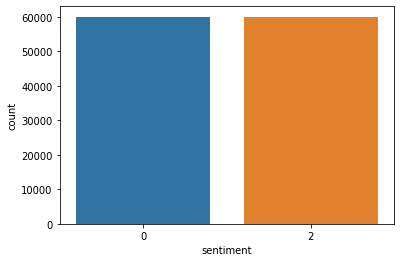

In [5]:
sns.countplot(df["sentiment"])

In [6]:
df.isna().sum()

review       1
rating       0
sentiment    0
dtype: int64

In [7]:
df = df.dropna(axis=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119999 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     119999 non-null  object
 1   rating     119999 non-null  int64 
 2   sentiment  119999 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ MB


### Cleaning

In [9]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = list(filter(lambda x: x, [x.lower() for x in texts.split(" ")]))

    return texts

In [10]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [11]:
df.head()

,review,rating,sentiment,review_cleaned
0,Mantap sekali,5,2,"[mantap, sekali]"
1,Sangat bagus,5,2,"[sangat, bagus]"
2,bagus,5,2,[bagus]
3,semoga sukses,5,2,"[semoga, sukses]"
4,Bagusss bangetttt❤️,5,2,"[bagusss, bangetttt]"


In [12]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

display(pd.DataFrame(word_length, columns=['word_length']).describe())
display(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

,word_length
count,119999.000000
mean,10.974091
std,13.843067
min,0.000000
25%,2.000000
50%,6.000000
75%,14.000000
max,306.000000


word_length    28.0
Name: 0.9, dtype: float64

In [13]:
sentiment_onehot = pd.DataFrame(pd.get_dummies(df['sentiment']))

## 2. LSTM Model

### Tokenize & Padding

In [14]:
tokenizer = Tokenizer(num_words=10000)

In [15]:
tokenizer.fit_on_texts(df['review_cleaned'])
seq = tokenizer.texts_to_sequences(df['review_cleaned'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (119999, 243), X_min: 0, X_max: 9999


In [17]:
y = df['sentiment'].map({0:0, 2:1})

In [18]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(76799, 243) (19200, 243) (24000, 243) (76799,) (19200,) (24000,)


In [19]:
y_train

33056     0
98237     1
82468     0
12163     1
73966     0
         ..
51343     0
24553     1
106087    1
74242     0
111541    1
Name: sentiment, Length: 76799, dtype: int64

### Create Model Layers

In [20]:
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


### Training Model

In [21]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
2400/2400 [==============================] - 548s 227ms/step - loss: 0.4020 - accuracy: 0.8367 - val_loss: 0.3769 - val_accuracy: 0.8492
Epoch 2/5
2400/2400 [==============================] - 587s 245ms/step - loss: 0.3463 - accuracy: 0.8597 - val_loss: 0.3651 - val_accuracy: 0.8508
Epoch 3/5
2400/2400 [==============================] - 619s 258ms/step - loss: 0.3178 - accuracy: 0.8706 - val_loss: 0.3720 - val_accuracy: 0.8518
Epoch 4/5
2400/2400 [==============================] - 529s 220ms/step - loss: 0.2949 - accuracy: 0.8795 - val_loss: 0.3846 - val_accuracy: 0.8515
Epoch 5/5
2400/2400 [==============================] - 536s 223ms/step - loss: 0.2750 - accuracy: 0.8876 - val_loss: 0.4103 - val_accuracy: 0.8451


<AxesSubplot:>

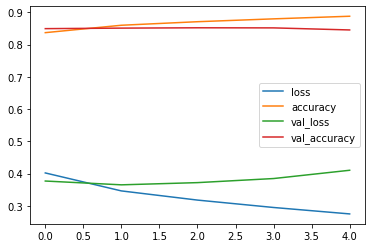

In [22]:
pd.DataFrame(history.history).plot()

### Evaluating Model

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     11994
           1       0.83      0.87      0.85     12006

    accuracy                           0.84     24000
   macro avg       0.85      0.84      0.84     24000
weighted avg       0.85      0.84      0.84     24000



<AxesSubplot:>

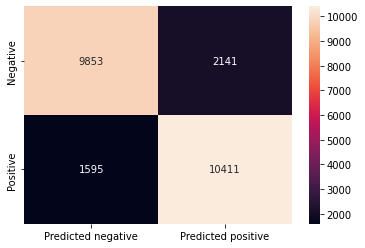

In [25]:
# y_test = np.argmax(y_test.to_numpy(), axis=1)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])